# Stimuli

### Import

In [4]:
import os
import random
import json
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from pandas              import json_normalize
from PIL                 import Image
from itertools           import combinations
from collections         import deque, Counter
from google.colab        import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
file_path= '/content/gdrive/MyDrive/stimuli_combination_2160.csv'
file_read = pd.read_csv(file_path)

### Sanitizing

In [6]:
file_read = file_read.replace(to_replace='\(', value="", regex=True)
file_read = file_read.replace(to_replace='\)', value="", regex=True)
file_read = file_read.replace(to_replace=' ', value="", regex=True)
file_read = file_read.replace(to_replace="'", value="", regex=True)

In [7]:
file_read

,img_card_0,img_card_1,img_card_2,int_card_0,int_card_1,int_card_2,digit_card_00,digit_card_01,digit_card_02,digit_card_03,digit_card_10,digit_card_11,digit_card_12,digit_card_13,digit_card_20,digit_card_21,digit_card_22,digit_card_23,is_set,same_cnt,diff_cnt,no_set
0,red_open_circle_black.png,red_open_circle_grey.png,red_open_circle_white.png,"0,0,0,0","0,0,0,1","0,0,0,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,0,"128,128,128","255,0,0",0.0,0,"255,255,255",1,3,1,0
1,red_open_circle_black.png,red_open_triangle_black.png,red_open_square_black.png,"0,0,0,0","0,0,1,0","0,0,2,0","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,0,0",0.0,4,"0,0,0",1,3,1,0
2,red_open_circle_black.png,red_open_triangle_black.png,yellow_open_triangle_white.png,"0,0,0,0","0,0,1,0","1,0,1,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,255,0",0.0,3,"255,255,255",0,1,0,1
3,red_open_circle_black.png,red_open_triangle_black.png,yellow_striped_square_white.png,"0,0,0,0","0,0,1,0","1,1,2,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","255,255,0",0.5,4,"255,255,255",0,0,1,1
4,red_open_circle_black.png,red_open_triangle_black.png,green_solid_triangle_white.png,"0,0,0,0","0,0,1,0","2,2,1,2","255,0,0",0.0,0,"0,0,0","255,0,0",0.0,3,"0,0,0","0,128,0",1.0,3,"255,255,255",0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,green_solid_circle_white.png,green_solid_triangle_black.png,green_solid_square_grey.png,"2,2,0,2","2,2,1,0","2,2,2,1","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"0,0,0","0,128,0",1.0,4,"128,128,128",1,2,2,0
2156,green_solid_circle_white.png,green_solid_triangle_grey.png,green_solid_square_black.png,"2,2,0,2","2,2,1,1","2,2,2,0","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"128,128,128","0,128,0",1.0,4,"0,0,0",1,2,2,0
2157,green_solid_circle_white.png,green_solid_triangle_white.png,green_solid_square_white.png,"2,2,0,2","2,2,1,2","2,2,2,2","0,128,0",1.0,0,"255,255,255","0,128,0",1.0,3,"255,255,255","0,128,0",1.0,4,"255,255,255",1,3,1,0
2158,green_solid_triangle_black.png,green_solid_triangle_grey.png,green_solid_triangle_white.png,"2,2,1,0","2,2,1,1","2,2,1,2","0,128,0",1.0,3,"0,0,0","0,128,0",1.0,3,"128,128,128","0,128,0",1.0,3,"255,255,255",1,3,1,0


### Reshape

In [8]:
digit_card = file_read[['int_card_0', 'int_card_1', 'int_card_2', 'is_set']]

In [9]:
zero = digit_card[str(digit_card.columns[0])].str.split(',', expand=True)
one = digit_card[str(digit_card.columns[1])].str.split(',', expand=True)
two = digit_card[str(digit_card.columns[2])].str.split(',', expand=True)
is_set = digit_card[str(digit_card.columns[3])]

In [10]:
stimuli = pd.concat([zero, one, two, is_set], ignore_index = True ,axis=1)

In [11]:
stimuli[12].value_counts()

1    1080
0    1080
Name: 12, dtype: int64

### Shuffle

In [12]:
shuffled_stimuli = stimuli.sample(frac=1)

In [13]:
shuffled_stimuli.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
908,0,1,1,1,0,2,1,0,1,2,2,0,0
1545,0,2,2,1,1,1,0,0,2,0,1,2,1
2143,2,1,1,0,2,1,1,1,2,1,1,2,1
407,0,0,1,2,0,2,2,2,2,1,1,2,0
1765,1,0,1,2,1,1,2,2,2,2,0,0,0


In [14]:
shuffled_stimuli = shuffled_stimuli.to_numpy()

In [15]:
shuffled_stimuli.shape

(2160, 13)

In [16]:
shuffled_stimuli.astype('float')

array([[0., 1., 1., ..., 2., 0., 0.],
       [0., 2., 2., ..., 1., 2., 1.],
       [2., 1., 1., ..., 1., 2., 1.],
       ...,
       [0., 0., 2., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

# DQN

### Import

In [17]:
import time
import json
import torch
import random
import torch.optim         as optim
import numpy               as np
import torch.nn            as nn
import matplotlib.pyplot   as plt
import torch.nn.functional as F
from collections           import namedtuple, deque
%matplotlib inline

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [19]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-7              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 1        # how often to update the network

### QNetwork

In [20]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        fc1_units = 256
        fc2_units = 256
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc2_units)
        self.fc4 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.seed = seed

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

### Replay Buffer

In [21]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Agent

In [27]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, dones = experiences
  
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute Q targets for current states 
        # https://github.com/niffler92/Bandit/blob/master/bandit/agent.py
        Q_targets = rewards + gamma * (rewards - Q_expected) * (1 - dones)
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Main

In [32]:
def dqn(n_episodes=shuffled_stimuli.shape[0], eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    agent = Agent(state_size = 12, action_size=2, seed=0)

    for i_episode in range(1, n_episodes-1):
      score = 0
      for t in range(1):
        state = shuffled_stimuli[i_episode][:-1].astype('float')
        action = agent.act(state, eps)
        
        if float(action) == float(shuffled_stimuli[i_episode][-1]):
          reward = 1
        else:
          reward = 0

        if i_episode != n_episodes:
          done = 0
        else:
          done = 1 
        # print("done:", done)

        agent.step(state, action, reward, done)
        score += reward
        if done:
            break 

      scores_window.append(score)  
      scores.append(np.mean(scores_window))  
      eps = max(eps_end, eps_decay*eps) # decrease epsilon
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
      if i_episode % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
      if len(scores_window)>=100 and np.mean(scores_window)>=99.99:
          print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
          torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
          break
        
    return scores

### Training

Episode 100	Average Score: 0.52
Episode 200	Average Score: 0.48
Episode 300	Average Score: 0.56
Episode 400	Average Score: 0.67
Episode 500	Average Score: 0.64
Episode 600	Average Score: 0.78
Episode 700	Average Score: 0.75
Episode 800	Average Score: 0.83
Episode 900	Average Score: 0.80
Episode 1000	Average Score: 0.81
Episode 1100	Average Score: 0.83
Episode 1200	Average Score: 0.88
Episode 1300	Average Score: 0.81
Episode 1400	Average Score: 0.92
Episode 1500	Average Score: 0.87
Episode 1600	Average Score: 0.94
Episode 1700	Average Score: 0.93
Episode 1800	Average Score: 0.93
Episode 1900	Average Score: 0.94
Episode 2000	Average Score: 0.93
Episode 2100	Average Score: 0.91
Episode 2158	Average Score: 0.89

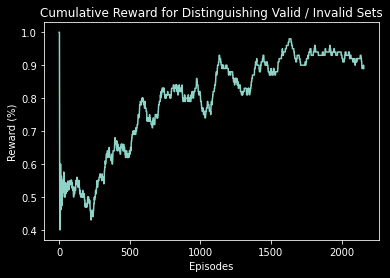

In [33]:
scores = dqn()

# plot the scores
plt.style.use('dark_background')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title("Cumulative Reward for Distinguishing Valid / Invalid Sets")
plt.ylabel('Reward (%)')
plt.xlabel('Episodes')
plt.show()